In [1]:
# IMA이미지를 불러오는 라이브러리
import pydicom

import numpy as np
import torch
import torchvision.transforms as transforms
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = [3.0, 3.0]
import seaborn as sns

root = '/root/code/'

# 데이터 탐구

## 1. 정규화

In [2]:
file_path = "/root/Mayo2016/L067/full_1mm/L067_FD_1_1.CT.0001.0032.2015.12.22.18.09.40.840353.358074963.IMA"
dicom_data = pydicom.dcmread(file_path)
dicom_data

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 192
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.1.4.64291.30000015122300005219400001540
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.3.12.2.1107.5.1.4
(0002, 0013) Implementation Version Name         SH: 'SIEMENS_S7VA44A'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.64291.30000015122300005219400001540
(0008, 0020) Study Date       

아래와 같이 작성을 하면 되지만, 나중에 정규화로 스케일링을 해주기에 사실 중복되어서 안해주어도 괜찮다. 그래도 의미를 살펴보는 관점에서 보자면, 

CT 이미지는 Hounsfield Unit (HU)라는 단위를 사용해 밀도를 측정합니다. RescaleSlope와 RescaleIntercept는 픽셀 데이터를 HU로 변환해, 예를 들어 물(0 HU)과 공기(-1000 HU)의 밀도를 구분할 수 있게 합니다.

REDCNN논문에도 나오는데, CT data의 표준 단위계는 공기 부분이 -1024, 물이 0, 뼈와 같은 부분들이 2000부근의 값이 직힙니다.

In [3]:
dicom_data.RescaleSlope, dicom_data.RescaleIntercept

('1.0', '-1024.0')

In [4]:
# 픽셀 데이터를 가져옴 (이미지 데이터)
img = dicom_data.pixel_array
img, img.shape # dtype=uint16로 음수가 안되는 정수이다.(unsinged int) <- 나중에 연산할 때 문제가 생긴다.

(array([[18, 14, 14, ...,  7,  9, 13],
        [24, 27, 31, ..., 11, 13, 19],
        [25, 26, 35, ..., 17, 20, 22],
        ...,
        [22, 11, 12, ..., 10,  9,  9],
        [29, 16, 11, ..., 12,  9, 12],
        [22, 15, 11, ..., 20, 13, 18]], dtype=uint16),
 (512, 512))

In [5]:
# 데이터 타입을 부호 있는 실수형(float32)으로 변환
img = img.astype(np.float32) 
img

array([[18., 14., 14., ...,  7.,  9., 13.],
       [24., 27., 31., ..., 11., 13., 19.],
       [25., 26., 35., ..., 17., 20., 22.],
       ...,
       [22., 11., 12., ..., 10.,  9.,  9.],
       [29., 16., 11., ..., 12.,  9., 12.],
       [22., 15., 11., ..., 20., 13., 18.]], dtype=float32)

In [6]:
# 원본값으로 변환(픽셀화, 스케일링, 실수화 진행)
img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
img

array([[-1006., -1010., -1010., ..., -1017., -1015., -1011.],
       [-1000.,  -997.,  -993., ..., -1013., -1011., -1005.],
       [ -999.,  -998.,  -989., ..., -1007., -1004., -1002.],
       ...,
       [-1002., -1013., -1012., ..., -1014., -1015., -1015.],
       [ -995., -1008., -1013., ..., -1012., -1015., -1012.],
       [-1002., -1009., -1013., ..., -1004., -1011., -1006.]],
      dtype=float32)

1843.0 -1024.0


<Axes: ylabel='Count'>

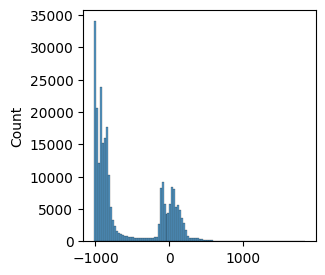

In [7]:
print(img.max(), img.min()) # 0~255의 크기가 아니다.
sns.histplot(img.flatten())

In [8]:
data = img.flatten()
np.mean(data), np.sqrt(np.var(data)) # 따라서 mean=-500, sd=500 으로 범위변경

(-575.94324, 465.33875)

4.686 -1.048


<Axes: ylabel='Count'>

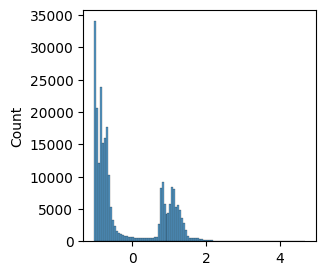

In [9]:
mu, sd = (-500,500)
scaled_img = (img - mu) / sd

print(scaled_img.max(), scaled_img.min())
sns.histplot(scaled_img.flatten()) # 대략 평균이 0이고, 표준편차가 1로 정규화가 되었다.

In [10]:
# # 굳이 변수변환 등을 하여, 해당픽셀분포를 정규분포로 바꿔줄 필요는 없다.
# # 우리가 사용할 모델이 VAE와 유사한데, VAE는 이가 필요없기 때문이다.

# from sklearn.preprocessing import QuantileTransformer
# import numpy as np

# # 예시 데이터 (현재 Z-스코어로 변환된 데이터라고 가정)
# # data는 Numpy 배열 또는 PyTorch Tensor 형태일 수 있음. 여기서는 Numpy 배열로 가정
# data = np.array(your_data)  # your_data는 실제 데이터 값으로 교체

# # QuantileTransformer 적용 (정규분포로 변환)
# qt = QuantileTransformer(output_distribution='normal')
# data_normalized = qt.fit_transform(data.reshape(-1, 1))

# # 다시 원래 형태로 변환 (reshape 필요시)
# data_normalized = data_normalized.reshape(your_original_shape)  # 원래 데이터 모양으로 변환


## 2. patch

In [11]:
img = np.expand_dims(scaled_img, axis=0) # C=1 로 늘려준다.
img.shape

(1, 512, 512)

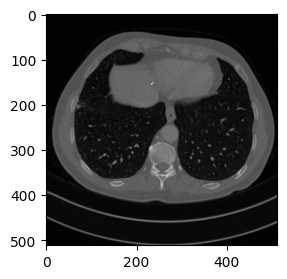

In [12]:
# 이미지 확인

plt.imshow(np.squeeze(img), cmap='gray')
plt.show()

추출된 패치 수: 81
각 패치의 크기: (1, 55, 55)


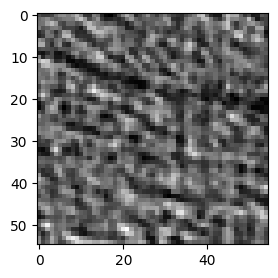

In [13]:
# 512x512이미지를 55x55사이즈로 변환 patch-size

import numpy as np

def extract_patches(img, patch_size, interval):
    patches = []
    _, height, width = img.shape
    for y in range(0, height - patch_size + 1, interval):
        for x in range(0, width - patch_size + 1, interval):
            patch = img[:, y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    return np.array(patches)

# 1x512x512 이미지에서 1x55x55 패치 추출
patch_size = 55
interval = 55
patches = extract_patches(img, patch_size, interval)

print(f"추출된 패치 수: {len(patches)}")
print(f"각 패치의 크기: {patches[0].shape}")

# 이미지 확인
plt.imshow(np.squeeze(patches[0]), cmap='gray')
plt.show()

### 이미지 자세히 보기

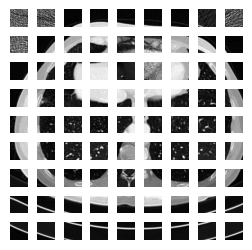

In [14]:
fig, axes = plt.subplots(9, 9, figsize=(3, 3))  # 9행 9열, 전체 크기 조절
fig.subplots_adjust(hspace=0.5, wspace=0.5)  # 간격 조절

for i in range(9*9):
    row = i // 9  # 9행 중 어느 행에 위치할지
    col = i % 9   # 9열 중 어느 열에 위치할지
    axes[row, col].imshow(np.squeeze(patches[i]), cmap='gray')
    axes[row, col].axis('off')  # 축 제거

plt.show()

## 3. Augmentation

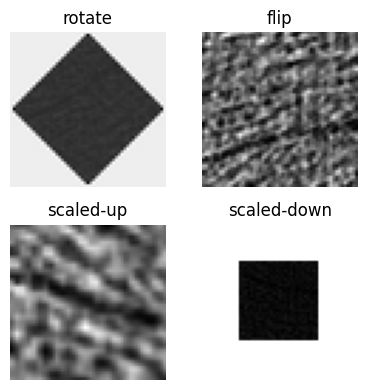

In [15]:
# rotate 45도, 상하좌우반전, 확대, 축소
from scipy.ndimage import rotate, zoom

# 첫번째 이미지에 대해 예시 수행
patch = patches[0]

# 1. 회전
rotated = rotate(patch, 45, axes=(1, 2), reshape=True) # 회전된 이미지가 손실되지 않도록 빈부분을 padding해서 이미지 크기가 커진다.
scale_factor = patch.shape[1] / rotated.shape[1]  # 78x78에서 55x55로 변환 비율 계산
rotated = zoom(rotated, (1, scale_factor, scale_factor))
if rotated.shape != (1, 55, 55):
    rotated = zoom(rotated, (1, 55/rotated.shape[1], 55/rotated.shape[2]))
# 2. 수직 뒤집기
flipped_v = np.flip(patch, axis=1)
# 3. 스케일링 (2배 확대)
scaled_up = zoom(patch, (1, 2, 2), order=1)
scaled_up_list = []
for i in range(2):  # 행 2개로 자르기
    for j in range(2):  # 열 2개로 자르기
        # 잘라낸 이미지 생성
        cropped_patch = scaled_up[:, i * 55: (i + 1) * 55, j * 55: (j + 1) * 55] # 원래 크기로 자르기
        scaled_up_list.append(cropped_patch)
# 4. 스케일링 (0.5배 축소)
scaled_down = zoom(patch, (1, 0.5, 0.5), order=1) # 선형 보간법 (order=1)
# 55/2=27.05->28, 28+13+14=55
scaled_down = np.pad(scaled_down, ((0, 0), (13, 14), (13, 14)), mode='constant') # 원래 크기로 채우기(padding이용)

images = [rotated, flipped_v, scaled_up_list[0], scaled_down]
titles = ['rotate', 'flip', 'scaled-up', 'scaled-down']

fig, axs = plt.subplots(2, 2, figsize=(4, 4))

for i, ax in enumerate(axs.flat):
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(titles[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

보통 스케일링은 image restoration task에서 사용이 되지 않는다고 한다

45도 회전 : CT 이미지는 각 축에서 촬영된 단면을 바탕으로 구성되기 때문에, 45도 회전은 원래 해부학적 구조가 왜곡될 수 있습니다. 특히, CT 데이터는 각도를 엄격하게 유지해야 병변의 위치와 모양을 제대로 파악할 수 있는데, 45도 회전은 이러한 해부학적 정렬을 깨뜨릴 위험이 있습니다. 대신, 90도 또는 180도 회전은 해부학적 구조의 왜곡이 최소화되면서도 데이터 다양성을 높일 수 있어, 45도 회전보다 안전한 선택

확대 (Zoom-in): 특정 부위의 세부 사항이 커지므로 모델이 원래 해상도보다 작은 정보에 의존해 학습할 가능성이 있습니다. 이렇게 되면 실제 사용 시 전체 이미지에 대한 처리 능력이 떨어질 수 있습니다.

축소 (Zoom-out): 이미지 해상도가 낮아지면서 세부 사항이 손실될 수 있습니다. 이는 저선량-고선량 CT 간의 세밀한 차이를 모델이 정확하게 학습하지 못하게 할 가능성이 있습니다.

In [16]:
import random

def augment_patches(patches, p=0.5):
    augmented_patches = []
    
    for patch in patches:
        # 원본 패치 추가
        augmented_patches.append(patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            rotated_clockwise = rotate(patch, 90, axes=(1, 2), reshape=False)
            augmented_patches.append(rotated_clockwise)
            rotated_counterclockwise = rotate(patch, -90, axes=(1, 2), reshape=False)
            augmented_patches.append(rotated_counterclockwise)
        if random.random() < p:
            # 2. 수직 뒤집기
            flipped_v = np.flip(patch, axis=1)
            augmented_patches.append(flipped_v)
        if random.random() < p:
            # 3. 수평 뒤집기
            flipped_h = np.flip(patch, axis=2)
            augmented_patches.append(flipped_h)

    return augmented_patches

# 패치 리스트를 사용하여 데이터 증강
augmented_patches = augment_patches(patches)

print(f"증강된 패치 수: {len(augmented_patches)}")
print(f"각 패치의 크기: {augmented_patches[0].shape}")

증강된 패치 수: 241
각 패치의 크기: (1, 55, 55)


# 데이터셋 만들기

## 1. 경로 정리

In [17]:
import glob

L_list = glob.glob('/root/Mayo2016/*')
L_list = [path.split('/')[-1] for path in L_list]
L_list.sort()
L_list

['L067',
 'L096',
 'L109',
 'L143',
 'L192',
 'L286',
 'L291',
 'L310',
 'L333',
 'L506']

In [18]:
data_label = ['quarter_1mm', 'full_1mm']

In [19]:
# X,y의 순서쌍 갯수가 일치한다.

for L in L_list:
  n1 = len(sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[0]}/*.IMA')))
  n2 = len(sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[0]}/*.IMA')))
  notation = ''
  if n1 != n2:
    notation = '<-'
  print(f"{L} : {n1}, {n2} {notation}")

L067 : 560, 560 
L096 : 823, 823 
L109 : 318, 318 
L143 : 585, 585 
L192 : 600, 600 
L286 : 525, 525 
L291 : 856, 856 
L310 : 533, 533 
L333 : 610, 610 
L506 : 526, 526 


In [20]:
# 모든 이미지가 512x512 사이즈이다.

for L in L_list:
  for label in data_label:
    path_list = sorted(glob.glob(f'/root/Mayo2016/{L}/{label}/*.IMA'))
    dicom_data = pydicom.dcmread(file_path)
    img = dicom_data.pixel_array
    assert img.shape == (512, 512)

### 이미지 순서 자세히 보기

In [21]:
# path1_list = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[0]}/*.IMA'))
# path1_list

In [22]:
# path2_list = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[1]}/*.IMA'))
# path2_list

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# ResNet50 모델 로드 (weights 사용으로 pretrained 경고 제거)
weights = models.ResNet50_Weights.IMAGENET1K_V1  # 가장 일반적으로 사용되는 가중치
resnet = models.resnet50(weights=weights)
resnet = nn.Sequential(*list(resnet.children())[:-1])  # 마지막 분류 레이어 제거 (특징 벡터 추출)

# ResNet50 모델을 평가 모드로 설정
resnet.eval()

# ResNet에 맞는 입력 형태로 변환하는 함수
transform = transforms.Compose([
  transforms.Resize((224, 224), antialias=True),  # antialias를 True로 설정
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 특징 추출 함수 (이미지를 matrix로 입력받음, 1x512x512 형태)
def extract_features(image_matrix):
  # Numpy 배열을 PyTorch 텐서로 변환
  image_matrix = torch.tensor(image_matrix, dtype=torch.float32)

  # 배치 차원 추가 (1채널 이미지를 3채널로 복제하기 위해 차원 확장)
  image_matrix = image_matrix.unsqueeze(0)  # (1, 1, 512, 512)

  # 1x512x512 -> 3x512x512로 변환 (채널 복제)
  image_matrix = image_matrix.repeat(1, 3, 1, 1)  # (1, 3, 512, 512)

  # ResNet에 맞는 입력 크기로 변환
  image_matrix = transform(image_matrix)

  # 특징 벡터 추출
  with torch.no_grad():
    features = resnet(image_matrix)  # (1, 2048, 1, 1) 형태로 출력
    features = features.squeeze().cpu().numpy()  # (2048,) 형태로 변환

  return features

# 유사도 계산 함수 (코사인 유사도)
def calculate_similarity(feature1, feature2):
  similarity = cosine_similarity([feature1], [feature2])
  return similarity[0][0]

# 예시 이미지 (image1, image2는 numpy로 가정된 1x512x512 배열)
image1 = np.random.rand(1, 512, 512)  # 가상의 1채널 이미지 예시
image2 = np.random.rand(1, 512, 512)  # 가상의 1채널 이미지 예시

# 두 이미지의 특징 추출
features1 = extract_features(image1)
features2 = extract_features(image2)

# 유사도 계산
similarity = calculate_similarity(features1, features2)
print(f"Similarity between the two images: {similarity:.4f}")

Similarity between the two images: 0.9894


In [24]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

### 쌍이 제대로 맞는지 확인

In [25]:
# 8분 정도 소요된다.

from tqdm import tqdm
import glob

sim_list = []

# L_list 루프에 tqdm 추가
for L in tqdm(L_list, desc="Processing L_list"):
    path1_list = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[0]}/*.IMA'))
    path2_list = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[1]}/*.IMA'))
    
    # path1_list 루프에 tqdm 추가
    for i in tqdm(range(len(path1_list)), desc="Processing path pairs", leave=False):
        # 유사도 계산
        image1 = normlize(path1_list[i])
        image2 = normlize(path2_list[i])
        features1 = extract_features(image1)
        features2 = extract_features(image2)
        similarity = calculate_similarity(features1, features2)
        sim_list.append(similarity)

print(f"Total similarities calculated: {len(sim_list)}")

Processing L_list:   0%|          | 0/10 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# # sim_list를 파일에 저장
# import pickle
# with open('sim_list.pkl', 'wb') as f:
#     pickle.dump(sim_list, f)

In [26]:
# sim_list 불러오기
import pickle
with open(root+'sim_list.pkl', 'rb') as f:
    sim_list = pickle.load(f)

(<Axes: ylabel='Count'>, 0.9961519)

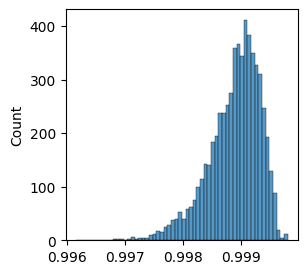

In [27]:
sns.histplot(sim_list), min(sim_list) # 최솟값이 0.996임으로 짝지어진 (X,y)는 sort를 하면 서로 잘 대응됨을 확인할 수 있다.

## 2. patch 제작 
- 데이터 전처리(정규화, patch, augmentation)

In [28]:
def normlize(path):
  dicom_data = pydicom.dcmread(path)
  img = dicom_data.pixel_array.astype(np.float32) * dicom_data.RescaleSlope + dicom_data.RescaleIntercept
  mu, sd = (-500,500)
  scaled_img = (img - mu) / sd
  img = np.expand_dims(scaled_img, axis=0)

  return img # 1x512x512

In [29]:
def extract_patches(img, patch_size=55, interval=55):
  patches = []
  _, height, width = img.shape
  for y in range(0, height - patch_size + 1, interval):
    for x in range(0, width - patch_size + 1, interval):
      patch = img[:, y:y + patch_size, x:x + patch_size]
      patches.append(patch)
  patches = np.array(patches)
  return patches # patch수x1x55x55

In [30]:
def augment_patches(X_patches, y_patches, p=0.5):
    import random
    X_augmented_patches, y_augmented_patches = [], []
    
    # random이 들어가기에, X랑 y를 동시에 넣어준다.
    for i, (X_patch, y_patch) in enumerate(zip(X_patches, y_patches)):
        # 원본 패치 추가
        X_augmented_patches.append(X_patch)
        y_augmented_patches.append(y_patch)

        if random.random() < p:
            # 1. 90, 270으로 돌려보자.(뒤집기랑 조금 다르긴 하지만, 점대칭 vs 선대칭, 그냥 +-90도만 쓰자.)
            X, y = rotate(X_patch, 90, axes=(1, 2), reshape=False), rotate(y_patch, 90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
            X, y = rotate(X_patch, -90, axes=(1, 2), reshape=False), rotate(y_patch, -90, axes=(1, 2), reshape=False)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 2. 수직 뒤집기
            X,y = np.flip(X_patch, axis=1),np.flip(y_patch, axis=1)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)
        if random.random() < p:
            # 3. 수평 뒤집기
            X,y = np.flip(X_patch, axis=2),np.flip(y_patch, axis=2)
            X_augmented_patches.append(X)
            y_augmented_patches.append(y)

    return np.array(X_augmented_patches), np.array(y_augmented_patches)

In [31]:
def patch_maker_W_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  X_augmented_patches, y_augmented_patches = augment_patches(X_patches, y_patches, p=0.5)
  return X_augmented_patches, y_augmented_patches

In [32]:
def patch_maker_WO_aug(X_dir, y_dir):
  X_img, y_img = normlize(X_dir), normlize(y_dir)
  X_patches = extract_patches(img=X_img, patch_size=55, interval=55)
  y_patches = extract_patches(img=y_img, patch_size=55, interval=55)
  return X_patches, y_patches

In [33]:
i,j = 0,0
X_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
y_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]
X_patches, y_patches = patch_maker_W_aug(X_dir, y_dir)
X_patches.shape, y_patches.shape

((248, 1, 55, 55), (248, 1, 55, 55))

In [34]:
i,j = 0,0
X_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
y_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]
X_patches, y_patches = patch_maker_WO_aug(X_dir, y_dir)
X_patches.shape, y_patches.shape

((81, 1, 55, 55), (81, 1, 55, 55))

### 이미지 자세히 보기

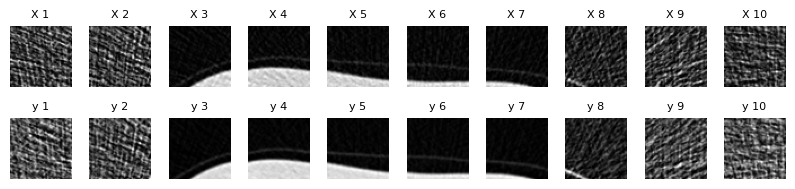

In [35]:
fig, axes = plt.subplots(2, 10, figsize=(10, 2))
fig.subplots_adjust(hspace=0.5, wspace=0.3) 

for i in range(10):
    axes[0, i].imshow(np.squeeze(X_patches[i]), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f'X {i+1}', fontsize=8)

    axes[1, i].imshow(np.squeeze(y_patches[i]), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f'y {i+1}', fontsize=8)

plt.show()

## 3. 데이터셋 최종

In [36]:
import os
from torch.utils.data import Dataset
import torch
import glob
from tqdm import tqdm

class CustomDataset(Dataset):
    def __init__(self, data_type, patch_maker, L_list):
        self.data_type = data_type
        self.patch_maker = patch_maker
        self.L_list = L_list
        self.image_pairs = []

        X_dir_list, y_dir_list = [], []
        for L in self.L_list:
            X_dir, y_dir = self.get_data_range(L)
            X_dir_list += X_dir
            y_dir_list += y_dir

        for X_dir, y_dir in tqdm(zip(X_dir_list, y_dir_list), total=len(X_dir_list), desc=f"{self.data_type} is processing"):
            X_patches, y_patches = self.patch_maker(X_dir, y_dir)
            for i in range(X_patches.shape[0]):
                X_patch, y_patch = torch.from_numpy(X_patches[i]), torch.from_numpy(y_patches[i]) # torch로 넣어주자.
                self.image_pairs.append((X_patch, y_patch))

    def get_data_range(self, L):
        """슬라이싱 범위를 설정하는 함수"""
        X_dir = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[0]}/*.IMA'))
        y_dir = sorted(glob.glob(f'/root/Mayo2016/{L}/{data_label[1]}/*.IMA'))
        n1, n2 = len(X_dir), len(y_dir)
        
        if self.data_type == 'train':
            X_range = X_dir[:int(n1 * 0.64)]
            y_range = y_dir[:int(n2 * 0.64)]
        elif self.data_type == 'val':
            X_range = X_dir[int(n1 * 0.64):int(n1 * 0.8)]
            y_range = y_dir[int(n2 * 0.64):int(n2 * 0.8)]
        else:  # test
            X_range = X_dir[int(n1 * 0.8):]
            y_range = y_dir[int(n2 * 0.8):]

        return X_range, y_range

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        X = self.image_pairs[idx][0]
        y = self.image_pairs[idx][1]
        return X, y

In [37]:
!pwd

/root/code/redcnn


In [38]:
%cd /root/code

/root/code


In [39]:
# # 대략 8분정도 걸린다.
train_dataset = CustomDataset('train',patch_maker_W_aug,L_list[:])
val_dataset = CustomDataset('val',patch_maker_WO_aug,L_list[:])
test_dataset = CustomDataset('test',patch_maker_WO_aug,L_list[:])

test is processing: 100%|██████████| 1190/1190 [00:07<00:00, 151.79it/s]


In [40]:
!pwd

/root/code


In [41]:
# 파일 경로 설정

root = '/root/code/'
train_path = root+'train_dataset.pt'
val_path = root+'val_dataset.pt'
test_path = root+'test_dataset.pt'

In [42]:
# 4분 정도 소요

# 데이터셋 저장
torch.save(train_dataset, train_path)
torch.save(val_dataset, val_path)
torch.save(test_dataset, test_path)

In [43]:
# 4분 정도 소요

# 데이터셋 불러오기
train_dataset = torch.load(train_path)
val_dataset = torch.load(val_path)
test_dataset = torch.load(test_path) # 45초

In [44]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

In [45]:
len(train_loader), len(val_loader), len(test_loader)

(57596, 4815, 6025)

In [46]:
X_train, y_train = next(iter(train_loader))
X_train.shape, y_train.shape

(torch.Size([16, 1, 55, 55]), torch.Size([16, 1, 55, 55]))

In [47]:
X_val, y_val = next(iter(val_loader))
X_val.shape, y_val.shape

(torch.Size([16, 1, 55, 55]), torch.Size([16, 1, 55, 55]))

In [48]:
X_test, y_test = next(iter(test_loader))
X_test.shape, y_test.shape

(torch.Size([16, 1, 55, 55]), torch.Size([16, 1, 55, 55]))

### 결과를 확인해보자.

In [49]:
def visualize_patches(X, y):
    fig, axes = plt.subplots(2, 16, figsize=(32, 4))  # 2행 16열로 설정
    fig.suptitle("Patches", fontsize=12, y=1.05)  # 전체 제목 추가

    for i in range(X.shape[0]):  # 16개의 이미지만큼 반복
        # X 데이터 시각화
        axes[0, i].imshow(np.squeeze(X[i]), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"X {i+1}", fontsize=25)
        
        # y 데이터 시각화
        axes[1, i].imshow(np.squeeze(y[i]), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title(f"y {i+1}", fontsize=25)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # 제목 위치 조정
    plt.show()

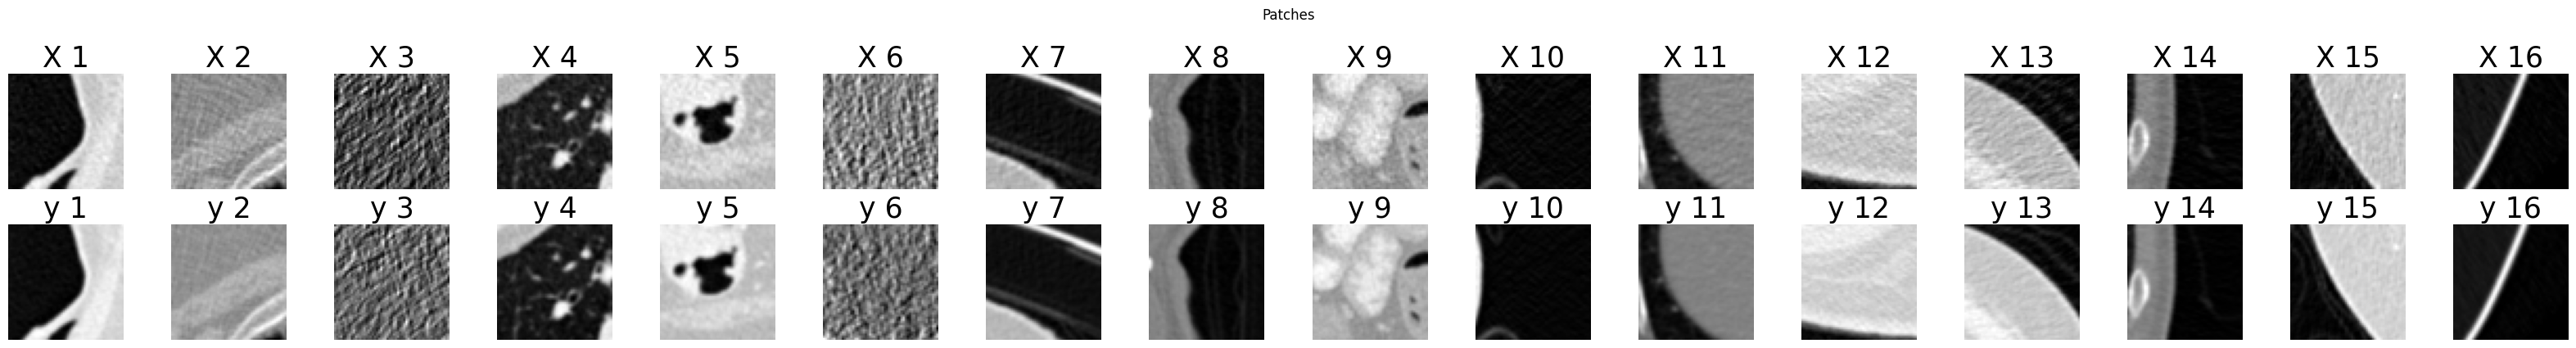

In [50]:
visualize_patches(X_train, y_train)

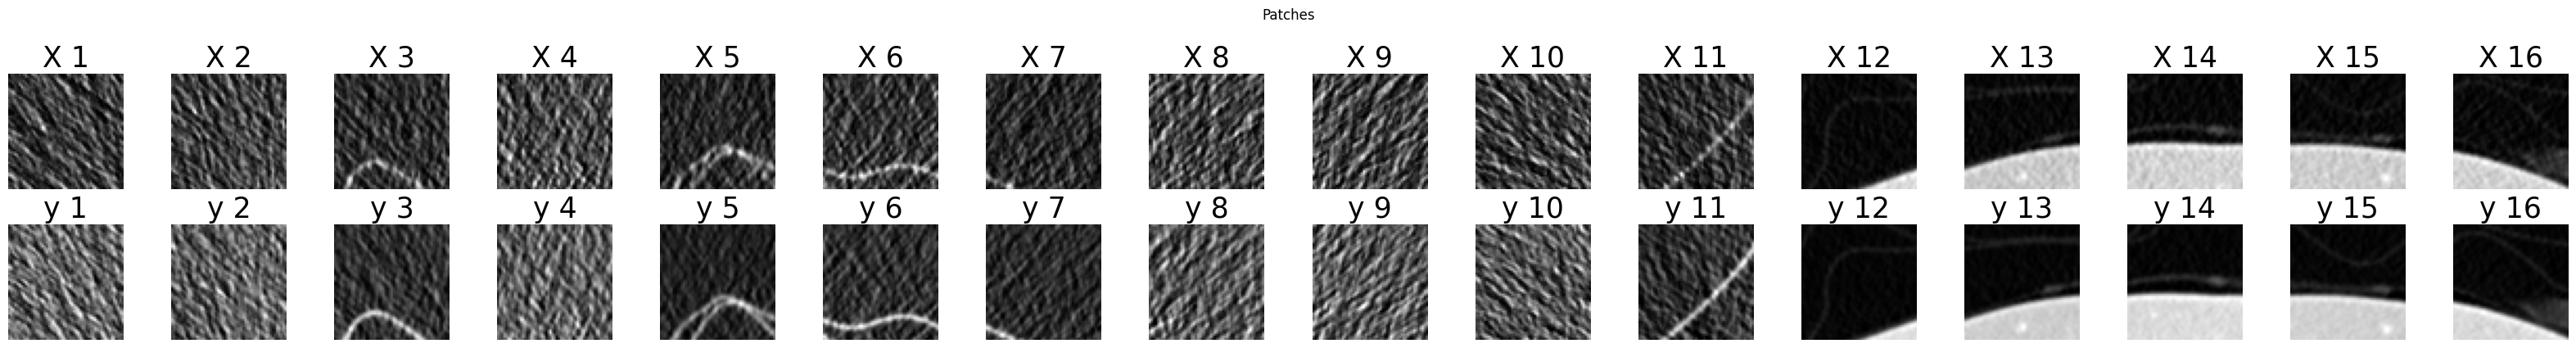

In [51]:
visualize_patches(X_val, y_val)

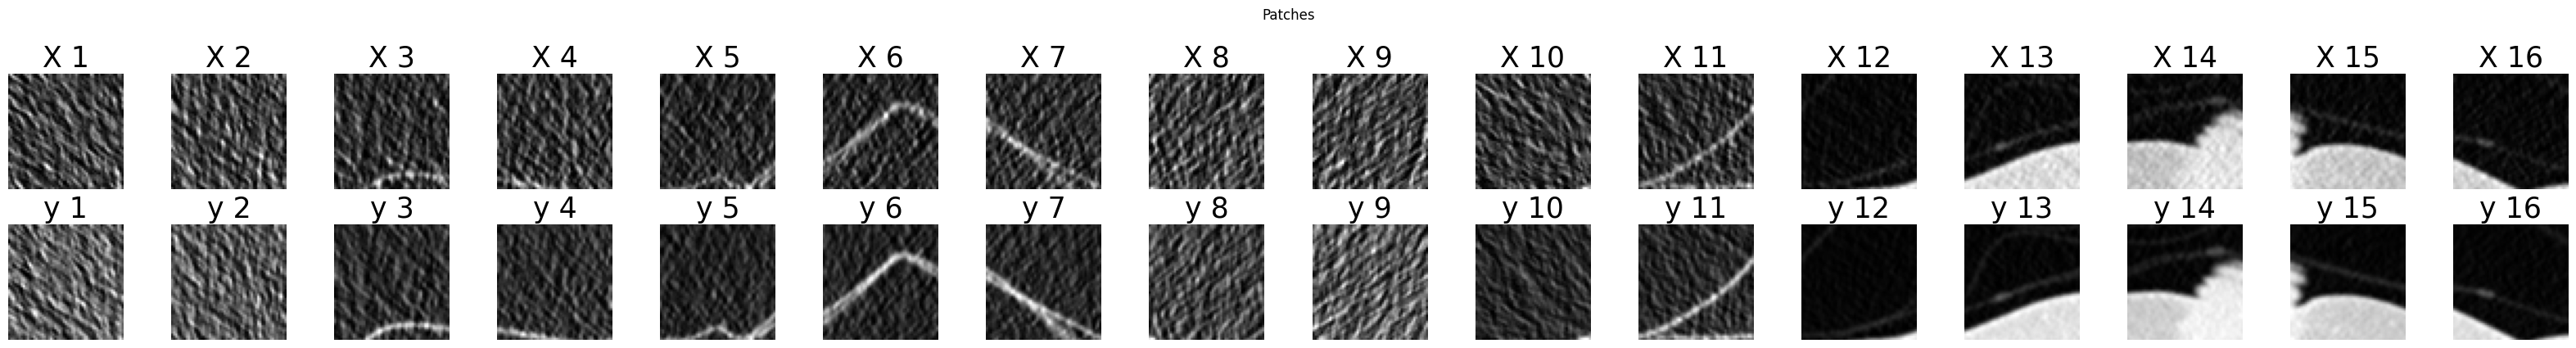

In [52]:
visualize_patches(X_test, y_test)

# 모델

In [152]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [153]:
import torch
import torch.nn as nn

class RedCNN(nn.Module):
    def __init__(self):
        super(RedCNN, self).__init__()

        # 인코더 부분
        self.conv1 = nn.Conv2d(1, 96, 5, 1, 0)
        self.conv2 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv3 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv4 = nn.Conv2d(96, 96, 5, 1, 0)
        self.conv5 = nn.Conv2d(96, 96, 5, 1, 0)
        
        # 디코더 부분
        self.deconv1 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv2 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv3 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv4 = nn.ConvTranspose2d(96, 96, 5, 1, 0)
        self.deconv_last = nn.ConvTranspose2d(96, 1, 5, 1, 0)

        self.relu = nn.ReLU()


    def forward(self, x):
        # 인코더 부분
        residual1 = x  # 첫 번째 잔차 저장
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        residual2 = x  # 두 번째 잔차 저장
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        residual3 = x  # 세 번째 잔차 저장
        x = self.relu(self.conv5(x))
        
        # 디코더 부분 (잔차를 더해줌)
        x = self.relu(self.deconv1(x)) + residual3  # 세 번째 잔차 연결
        x = self.relu(self.deconv2(x))
        x = self.relu((self.deconv3(x)) + residual2)  # 두 번째 잔차 연결
        x = self.relu(self.deconv4(x))
        x = self.deconv_last(x) + residual1  # 첫 번째 잔차 연결
        
        return x


In [154]:
model = RedCNN().to(device)
model

RedCNN(
  (conv1): Conv2d(1, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (conv5): Conv2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv1): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv2): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv3): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv4): ConvTranspose2d(96, 96, kernel_size=(5, 5), stride=(1, 1))
  (deconv_last): ConvTranspose2d(96, 1, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
)

In [155]:
%cd /root/code

import utils.EarlyStopping
import utils.LRScheduler
import utils.train_eval_util
import importlib
importlib.reload(utils.EarlyStopping)
importlib.reload(utils.LRScheduler)
importlib.reload(utils.train_eval_util)

/root/code


<module 'utils.train_eval_util' from '/root/code/utils/train_eval_util.py'>

In [156]:
import torch.nn as nn
criterion = nn.MSELoss()

from utils.EarlyStopping import *
from utils.LRScheduler import *
from utils.train_eval_util import train, evaluate

learning_rate = 1e-5
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate)


early_stopping = EarlyStopping(patience = 7, # 7번까지는 개선이 안되어도 봐준다.
                               min_delta = 1e-5) # 이정도는 개선이 되어야한다. 아니면 위의 patience까지 count하다가 stop


scheduler = LRScheduler(optimizer = optimizer,
                        patience = 5,
                        min_lr = 1e-10,
                        factor = 0.5)

In [157]:
import torch
from tqdm import tqdm

interval = 1000

def train(model, train_loader, optimizer, criterion, device, epoch):
    model.train()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    for i, data in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch} - Training"):
        X, y = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        X_hat = model(X)
        loss = criterion(X_hat, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(train_loader.dataset)

def evaluate(model, loader, criterion, device, epoch):
    model.eval()
    running_loss = 0.0
    loss_list = []
    total_loss = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch} - Evaluating"):
            X, y = data[0].to(device), data[1].to(device)
            X_hat = model(X)
            loss = criterion(X_hat, y)

            running_loss += loss.item() * X.size(0)

            if i % interval == interval-1:
                interval_loss = running_loss / interval
                loss_list.append(interval_loss)
                total_loss += running_loss
                running_loss = 0.0
                tqdm.write(f'train loss : {interval_loss}')

    return loss_list, total_loss / len(loader.dataset)

### 참고사항

In [158]:
print(f'X : {X_test.shape}\nX_hat : {model(X_test.to(device)).shape}\ny : {y_test.shape}')

X : torch.Size([81, 1, 55, 55])
X_hat : torch.Size([81, 1, 55, 55])
y : torch.Size([81, 1, 55, 55])


In [159]:
X_train, y_train = next(iter(train_loader))
X_hat = model(X_train)

X_train.shape, y_train.shape, X_hat.shape

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
conv_layer = nn.Conv2d(1, 96, 5, 1, 0)
conv_layer(X_train).shape

torch.Size([16, 96, 51, 51])

# 학습

In [160]:
!pwd

/root/code


In [161]:
%cd /root/code/redcnn/base

/root/code/redcnn/base


In [162]:
epochs = 2 # 각 epoch마다 train(20분), valid(2분)이 소요된다.
best_valid_loss = float('inf')
train_loss_per_iter = []
train_loss_per_epoch = []
val_loss_per_iter = []
val_loss_per_epoch = []

for epoch in range(epochs):
    loss_list, total_loss = train(model, train_loader, optimizer, criterion, device, epoch)
    train_loss_per_iter.append(loss_list)
    train_loss_per_epoch.append(total_loss)

    loss_list, total_loss = evaluate(model, val_loader, criterion, device, epoch)
    val_loss_per_iter.append(loss_list)
    val_loss_per_epoch.append(total_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_per_epoch[-1]:.4f}, Valid Loss: {val_loss_per_epoch[-1]:.4f}")

    valid_loss = val_loss_per_epoch[-1]
    scheduler(valid_loss)

    if (early_stopping(valid_loss)):
        break

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "./" + 'red_cnn' + ".pth")

Epoch 0 - Training:   0%|          | 0/57596 [00:00<?, ?it/s]

Epoch 0 - Training:   2%|▏         | 1006/57596 [00:19<18:43, 50.39it/s]

train loss : 0.07381187352538109


Epoch 0 - Training:   3%|▎         | 2008/57596 [00:39<18:23, 50.36it/s]

train loss : 0.05599561112560332


Epoch 0 - Training:   5%|▌         | 3010/57596 [00:59<18:03, 50.39it/s]

train loss : 0.052407963918522


Epoch 0 - Training:   7%|▋         | 4006/57596 [01:19<17:42, 50.43it/s]

train loss : 0.04918315788172185


Epoch 0 - Training:   9%|▊         | 5008/57596 [01:38<17:22, 50.45it/s]

train loss : 0.04763073918223381


Epoch 0 - Training:  10%|█         | 6010/57596 [01:58<17:03, 50.41it/s]

train loss : 0.04617726032063365


Epoch 0 - Training:  12%|█▏        | 7006/57596 [02:18<16:44, 50.39it/s]

train loss : 0.045571604087948796


Epoch 0 - Training:  14%|█▍        | 8008/57596 [02:37<16:23, 50.41it/s]

train loss : 0.04419052651710808


Epoch 0 - Training:  16%|█▌        | 9010/57596 [02:57<16:04, 50.37it/s]

train loss : 0.04296687046810985


Epoch 0 - Training:  17%|█▋        | 10006/57596 [03:17<15:43, 50.44it/s]

train loss : 0.04254315865971148


Epoch 0 - Training:  19%|█▉        | 11008/57596 [03:37<15:22, 50.48it/s]

train loss : 0.04252438515983522


Epoch 0 - Training:  21%|██        | 12010/57596 [03:56<15:03, 50.48it/s]

train loss : 0.042334024626761675


Epoch 0 - Training:  23%|██▎       | 13006/57596 [04:16<14:44, 50.42it/s]

train loss : 0.04181174034252763


Epoch 0 - Training:  24%|██▍       | 14008/57596 [04:36<14:24, 50.44it/s]

train loss : 0.04164432615786791


Epoch 0 - Training:  26%|██▌       | 15010/57596 [04:55<14:06, 50.30it/s]

train loss : 0.04088470817729831


Epoch 0 - Training:  28%|██▊       | 16006/57596 [05:15<13:44, 50.44it/s]

train loss : 0.040473298605531456


Epoch 0 - Training:  30%|██▉       | 17008/57596 [05:35<13:25, 50.41it/s]

train loss : 0.04015083085559309


Epoch 0 - Training:  31%|███▏      | 18010/57596 [05:55<13:05, 50.40it/s]

train loss : 0.04021853996440768


Epoch 0 - Training:  33%|███▎      | 19006/57596 [06:14<12:46, 50.37it/s]

train loss : 0.03963581288605928


Epoch 0 - Training:  35%|███▍      | 20008/57596 [06:34<12:25, 50.39it/s]

train loss : 0.039588315730914474


Epoch 0 - Training:  36%|███▋      | 21010/57596 [06:54<12:05, 50.43it/s]

train loss : 0.0400247600544244


Epoch 0 - Training:  38%|███▊      | 22006/57596 [07:13<11:47, 50.34it/s]

train loss : 0.03954564988799393


Epoch 0 - Training:  40%|███▉      | 23008/57596 [07:33<11:25, 50.45it/s]

train loss : 0.039533385375514624


Epoch 0 - Training:  42%|████▏     | 24010/57596 [07:53<11:06, 50.39it/s]

train loss : 0.03933376375027001


Epoch 0 - Training:  43%|████▎     | 25006/57596 [08:13<10:45, 50.47it/s]

train loss : 0.03869867230765522


Epoch 0 - Training:  45%|████▌     | 26008/57596 [08:32<10:26, 50.38it/s]

train loss : 0.03844328018650413


Epoch 0 - Training:  47%|████▋     | 27010/57596 [08:52<10:06, 50.40it/s]

train loss : 0.03870478674955666


Epoch 0 - Training:  49%|████▊     | 28006/57596 [09:12<09:46, 50.45it/s]

train loss : 0.038218509912490845


Epoch 0 - Training:  50%|█████     | 29008/57596 [09:31<09:26, 50.43it/s]

train loss : 0.038603957250714305


Epoch 0 - Training:  52%|█████▏    | 30010/57596 [09:51<09:07, 50.35it/s]

train loss : 0.03809247395955026


Epoch 0 - Training:  54%|█████▍    | 31006/57596 [10:11<08:47, 50.39it/s]

train loss : 0.03761652013286948


Epoch 0 - Training:  56%|█████▌    | 32008/57596 [10:31<08:27, 50.45it/s]

train loss : 0.038537707617506384


Epoch 0 - Training:  57%|█████▋    | 33010/57596 [10:50<08:07, 50.45it/s]

train loss : 0.03807989034987986


Epoch 0 - Training:  59%|█████▉    | 34006/57596 [11:10<07:48, 50.39it/s]

train loss : 0.03747602621465922


Epoch 0 - Training:  61%|██████    | 35008/57596 [11:30<07:27, 50.43it/s]

train loss : 0.0382297224868089


Epoch 0 - Training:  63%|██████▎   | 36010/57596 [11:49<07:07, 50.51it/s]

train loss : 0.03768474814482033


Epoch 0 - Training:  64%|██████▍   | 37006/57596 [12:09<06:48, 50.42it/s]

train loss : 0.03756569548696279


Epoch 0 - Training:  66%|██████▌   | 38008/57596 [12:29<06:28, 50.45it/s]

train loss : 0.03737088119052351


Epoch 0 - Training:  68%|██████▊   | 39010/57596 [12:49<06:08, 50.47it/s]

train loss : 0.03780035406723618


Epoch 0 - Training:  69%|██████▉   | 40006/57596 [13:08<05:49, 50.37it/s]

train loss : 0.03739490792900324


Epoch 0 - Training:  71%|███████   | 41008/57596 [13:28<05:28, 50.47it/s]

train loss : 0.0369597603585571


Epoch 0 - Training:  73%|███████▎  | 42010/57596 [13:48<05:08, 50.56it/s]

train loss : 0.03709600363485515


Epoch 0 - Training:  75%|███████▍  | 43006/57596 [14:07<04:49, 50.38it/s]

train loss : 0.036998526343144475


Epoch 0 - Training:  76%|███████▋  | 44008/57596 [14:27<04:29, 50.46it/s]

train loss : 0.03728925714455545


Epoch 0 - Training:  78%|███████▊  | 45010/57596 [14:47<04:09, 50.38it/s]

train loss : 0.036889400498941544


Epoch 0 - Training:  80%|███████▉  | 46006/57596 [15:06<03:49, 50.42it/s]

train loss : 0.03718573674745858


Epoch 0 - Training:  82%|████████▏ | 47008/57596 [15:26<03:29, 50.49it/s]

train loss : 0.03664488280005753


Epoch 0 - Training:  83%|████████▎ | 48010/57596 [15:46<03:10, 50.43it/s]

train loss : 0.03729026254825294


Epoch 0 - Training:  85%|████████▌ | 49006/57596 [16:05<02:50, 50.44it/s]

train loss : 0.03727518811263144


Epoch 0 - Training:  87%|████████▋ | 50008/57596 [16:25<02:30, 50.53it/s]

train loss : 0.03729514654912054


Epoch 0 - Training:  89%|████████▊ | 51010/57596 [16:45<02:10, 50.47it/s]

train loss : 0.03680473727174103


Epoch 0 - Training:  90%|█████████ | 52006/57596 [17:05<01:50, 50.43it/s]

train loss : 0.036759319150820376


Epoch 0 - Training:  92%|█████████▏| 53008/57596 [17:24<01:30, 50.43it/s]

train loss : 0.03691912226565182


Epoch 0 - Training:  94%|█████████▍| 54010/57596 [17:44<01:11, 50.40it/s]

train loss : 0.03664279988221824


Epoch 0 - Training:  96%|█████████▌| 55006/57596 [18:04<00:51, 50.46it/s]

train loss : 0.03628101015463472


Epoch 0 - Training:  97%|█████████▋| 56008/57596 [18:23<00:31, 50.45it/s]

train loss : 0.0362385514639318


Epoch 0 - Training:  99%|█████████▉| 57010/57596 [18:43<00:11, 50.48it/s]

train loss : 0.036333892671391366


Epoch 0 - Evaluating:  21%|██        | 1014/4815 [00:08<00:30, 123.59it/s]

train loss : 0.042553982730954884


Epoch 0 - Evaluating:  42%|████▏     | 2015/4815 [00:16<00:22, 123.78it/s]

train loss : 0.0459053115490824


Epoch 0 - Evaluating:  63%|██████▎   | 3016/4815 [00:24<00:14, 123.89it/s]

train loss : 0.030465967423282565


Epoch 0 - Evaluating:  83%|████████▎ | 4017/4815 [00:32<00:06, 123.68it/s]

train loss : 0.0339762096023187


Epoch 0 - Evaluating: 100%|██████████| 4815/4815 [00:38<00:00, 124.63it/s]


Epoch [1/2], Train Loss: 0.0025, Valid Loss: 0.0020


Epoch 1 - Training:   2%|▏         | 1010/57596 [00:19<18:38, 50.59it/s]

train loss : 0.036750613134354355


Epoch 1 - Training:   3%|▎         | 2006/57596 [00:39<18:20, 50.51it/s]

train loss : 0.03631092834752053


Epoch 1 - Training:   5%|▌         | 3008/57596 [00:59<18:00, 50.51it/s]

train loss : 0.036086677426472306


Epoch 1 - Training:   7%|▋         | 4010/57596 [01:18<17:38, 50.64it/s]

train loss : 0.03613709321990609


Epoch 1 - Training:   9%|▊         | 5006/57596 [01:38<17:20, 50.54it/s]

train loss : 0.03599810237810016


Epoch 1 - Training:  10%|█         | 6008/57596 [01:58<17:02, 50.47it/s]

train loss : 0.03691200668178499


Epoch 1 - Training:  12%|█▏        | 7010/57596 [02:17<16:39, 50.60it/s]

train loss : 0.0358273475561291


Epoch 1 - Training:  14%|█▍        | 8006/57596 [02:37<16:20, 50.58it/s]

train loss : 0.03598202274367213


Epoch 1 - Training:  16%|█▌        | 9008/57596 [02:57<16:00, 50.58it/s]

train loss : 0.03668531152792275


Epoch 1 - Training:  17%|█▋        | 10010/57596 [03:16<15:40, 50.60it/s]

train loss : 0.035663853803649545


Epoch 1 - Training:  19%|█▉        | 11006/57596 [03:36<15:23, 50.43it/s]

train loss : 0.036310466999188065


Epoch 1 - Training:  21%|██        | 12008/57596 [03:56<15:01, 50.57it/s]

train loss : 0.03605432480946183


Epoch 1 - Training:  23%|██▎       | 13010/57596 [04:15<14:41, 50.58it/s]

train loss : 0.035950170092284676


Epoch 1 - Training:  24%|██▍       | 14006/57596 [04:35<14:22, 50.52it/s]

train loss : 0.035669650554656984


Epoch 1 - Training:  26%|██▌       | 15008/57596 [04:54<14:01, 50.62it/s]

train loss : 0.03582495092507452


Epoch 1 - Training:  28%|██▊       | 16010/57596 [05:14<13:41, 50.65it/s]

train loss : 0.03575196534022689


Epoch 1 - Training:  30%|██▉       | 17006/57596 [05:34<13:21, 50.62it/s]

train loss : 0.03618154168687761


Epoch 1 - Training:  31%|███▏      | 18008/57596 [05:53<13:03, 50.55it/s]

train loss : 0.03576371549442411


Epoch 1 - Training:  33%|███▎      | 19010/57596 [06:13<12:43, 50.55it/s]

train loss : 0.03562543931975961


Epoch 1 - Training:  35%|███▍      | 20006/57596 [06:33<12:22, 50.60it/s]

train loss : 0.03618641565926373


Epoch 1 - Training:  36%|███▋      | 21008/57596 [06:52<12:01, 50.68it/s]

train loss : 0.035801428308710456


Epoch 1 - Training:  38%|███▊      | 22010/57596 [07:12<11:43, 50.58it/s]

train loss : 0.03590208015125245


Epoch 1 - Training:  40%|███▉      | 23006/57596 [07:32<11:23, 50.64it/s]

train loss : 0.03549991789925844


Epoch 1 - Training:  42%|████▏     | 24008/57596 [07:51<11:03, 50.63it/s]

train loss : 0.035987078458070754


Epoch 1 - Training:  43%|████▎     | 25010/57596 [08:11<10:43, 50.61it/s]

train loss : 0.03544099423661828


Epoch 1 - Training:  45%|████▌     | 26006/57596 [08:30<10:24, 50.55it/s]

train loss : 0.035417882077395914


Epoch 1 - Training:  47%|████▋     | 27008/57596 [08:50<10:04, 50.57it/s]

train loss : 0.03513682004250586


Epoch 1 - Training:  49%|████▊     | 28010/57596 [09:10<09:45, 50.49it/s]

train loss : 0.03551309533417225


Epoch 1 - Training:  50%|█████     | 29006/57596 [09:29<09:24, 50.61it/s]

train loss : 0.035349127128720285


Epoch 1 - Training:  52%|█████▏    | 30008/57596 [09:49<09:05, 50.54it/s]

train loss : 0.035159224764443935


Epoch 1 - Training:  54%|█████▍    | 31010/57596 [10:09<08:45, 50.56it/s]

train loss : 0.03508671006187797


Epoch 1 - Training:  56%|█████▌    | 32006/57596 [10:28<08:25, 50.61it/s]

train loss : 0.03543614838272333


Epoch 1 - Training:  57%|█████▋    | 33008/57596 [10:48<08:05, 50.60it/s]

train loss : 0.03545435628760606


Epoch 1 - Training:  59%|█████▉    | 34010/57596 [11:08<07:45, 50.63it/s]

train loss : 0.03510082135722041


Epoch 1 - Training:  61%|██████    | 35006/57596 [11:27<07:25, 50.67it/s]

train loss : 0.035615749940276144


Epoch 1 - Training:  63%|██████▎   | 36008/57596 [11:47<07:06, 50.64it/s]

train loss : 0.035490126157179475


Epoch 1 - Training:  64%|██████▍   | 37010/57596 [12:07<06:47, 50.54it/s]

train loss : 0.03554880412109196


Epoch 1 - Training:  66%|██████▌   | 38006/57596 [12:26<06:27, 50.59it/s]

train loss : 0.035466215280815956


Epoch 1 - Training:  68%|██████▊   | 39008/57596 [12:46<06:07, 50.57it/s]

train loss : 0.03522112020105123


Epoch 1 - Training:  69%|██████▉   | 40010/57596 [13:05<05:47, 50.62it/s]

train loss : 0.03508754627779126


Epoch 1 - Training:  71%|███████   | 41006/57596 [13:25<05:28, 50.56it/s]

train loss : 0.03555649457499385


Epoch 1 - Training:  73%|███████▎  | 42008/57596 [13:45<05:07, 50.66it/s]

train loss : 0.03506475979834795


Epoch 1 - Training:  75%|███████▍  | 43010/57596 [14:04<04:48, 50.64it/s]

train loss : 0.035348615996539594


Epoch 1 - Training:  76%|███████▋  | 44006/57596 [14:24<04:28, 50.58it/s]

train loss : 0.035076963607221845


Epoch 1 - Training:  78%|███████▊  | 45008/57596 [14:44<04:08, 50.59it/s]

train loss : 0.03555249735526741


Epoch 1 - Training:  80%|███████▉  | 46010/57596 [15:03<03:48, 50.63it/s]

train loss : 0.03453279716148973


Epoch 1 - Training:  82%|████████▏ | 47006/57596 [15:23<03:29, 50.62it/s]

train loss : 0.03537285928428173


Epoch 1 - Training:  83%|████████▎ | 48008/57596 [15:42<03:09, 50.67it/s]

train loss : 0.03485624579340219


Epoch 1 - Training:  85%|████████▌ | 49010/57596 [16:02<02:49, 50.62it/s]

train loss : 0.03467209600657225


Epoch 1 - Training:  87%|████████▋ | 50006/57596 [16:22<02:29, 50.61it/s]

train loss : 0.035454283095896245


Epoch 1 - Training:  89%|████████▊ | 51008/57596 [16:41<02:10, 50.64it/s]

train loss : 0.03484771065786481


Epoch 1 - Training:  90%|█████████ | 52010/57596 [17:01<01:50, 50.56it/s]

train loss : 0.034948683882132174


Epoch 1 - Training:  92%|█████████▏| 53006/57596 [17:21<01:30, 50.59it/s]

train loss : 0.03445435199141502


Epoch 1 - Training:  94%|█████████▍| 54008/57596 [17:40<01:10, 50.66it/s]

train loss : 0.03502979189157486


Epoch 1 - Training:  96%|█████████▌| 55010/57596 [18:00<00:51, 50.64it/s]

train loss : 0.03520200037956238


Epoch 1 - Training:  97%|█████████▋| 56006/57596 [18:20<00:31, 50.59it/s]

train loss : 0.03488891321700066


Epoch 1 - Training:  99%|█████████▉| 57008/57596 [18:39<00:11, 50.61it/s]

train loss : 0.03518005392886698


Epoch 1 - Evaluating:  21%|██        | 1014/4815 [00:08<00:30, 124.54it/s]

train loss : 0.04114121841546148


Epoch 1 - Evaluating:  42%|████▏     | 2015/4815 [00:16<00:22, 124.43it/s]

train loss : 0.04409502293309197


Epoch 1 - Evaluating:  63%|██████▎   | 3016/4815 [00:24<00:14, 124.46it/s]

train loss : 0.02922570538893342


Epoch 1 - Evaluating:  83%|████████▎ | 4017/4815 [00:32<00:06, 124.41it/s]

train loss : 0.032479759447276595


Epoch 1 - Evaluating: 100%|██████████| 4815/4815 [00:38<00:00, 125.32it/s]

Epoch [2/2], Train Loss: 0.0022, Valid Loss: 0.0019


In [163]:
import pickle

data_to_save = {
    'train_loss_per_iter': train_loss_per_iter,
    'val_loss_per_iter': val_loss_per_iter,
    'train_loss_per_epoch': train_loss_per_epoch,
    'val_loss_per_epoch': val_loss_per_epoch
}

for filename, data in data_to_save.items():
    with open(f'{filename}.pkl', 'wb') as f:
        pickle.dump(data, f)

In [164]:
import pickle

filenames = [
    'train_loss_per_iter.pkl',
    'val_loss_per_iter.pkl',
    'train_loss_per_epoch.pkl',
    'val_loss_per_epoch.pkl'
]

variables = [
    'train_loss_per_iter',
    'val_loss_per_iter',
    'train_loss_per_epoch',
    'val_loss_per_epoch'
]

data_to_load = dict(zip(filenames, variables))

for filename, variable_name in data_to_load.items():
    with open(filename, 'rb') as f:
        globals()[variable_name] = pickle.load(f)

In [165]:
train_flatten, val_flatten = [item for sublist in train_loss_per_iter for item in sublist], [item for sublist in val_loss_per_iter for item in sublist]

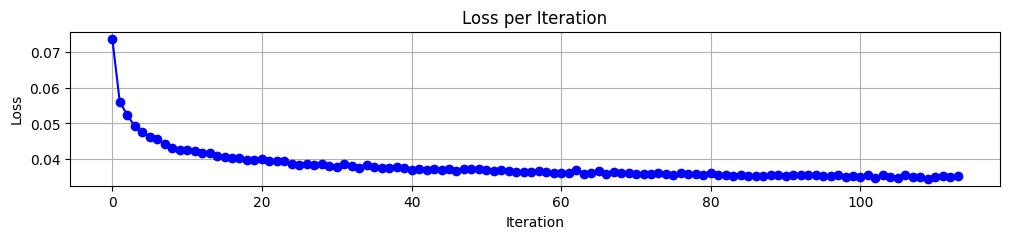

In [166]:
plt.figure(figsize=(12, 2))

# 반복 단위 손실 그래프
plt.plot(train_flatten, label='Train (per iter)', linestyle='-', marker='o', color='blue')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

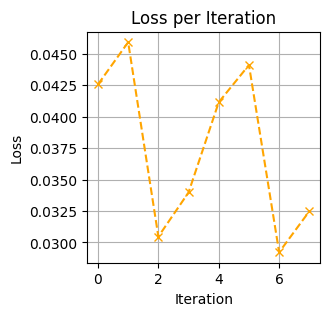

In [167]:
plt.plot(val_flatten, label='Validation (per iter)', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

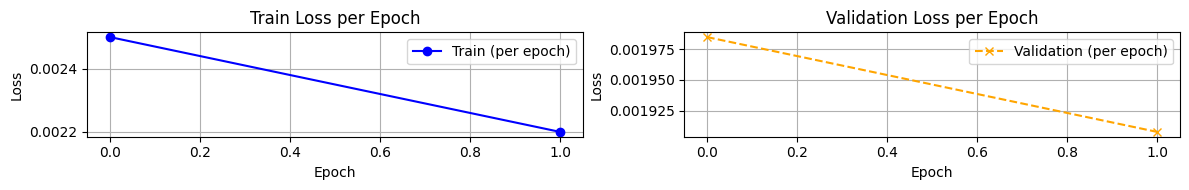

In [168]:
# 1행 2열 레이아웃 생성
fig, axes = plt.subplots(1, 2, figsize=(12, 2))  # 그래프 크기 조정

# Train loss per epoch 그래프
axes[0].plot(train_loss_per_epoch, label='Train (per epoch)', linestyle='-', marker='o', color='blue')
axes[0].set_title("Train Loss per Epoch")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# Validation loss per epoch 그래프
axes[1].plot(val_loss_per_epoch, label='Validation (per epoch)', linestyle='--', marker='x', color='orange')
axes[1].set_title("Validation Loss per Epoch")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

# 평가

In [169]:
!pwd

/root/code/redcnn/base


In [170]:
%cd /root/code/redcnn/base

/root/code/redcnn/base


In [171]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## batch size 16

### loss 추이 관찰

In [172]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('red_cnn.pth'))

<All keys matched successfully>

In [173]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
len(test_loader)

6025

In [174]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  17%|█▋        | 1022/6025 [00:08<00:40, 122.84it/s]

train loss : 0.03593716791737825


Evaluating:  34%|███▎      | 2023/6025 [00:16<00:32, 122.88it/s]

train loss : 0.03295149901788682


Evaluating:  50%|█████     | 3024/6025 [00:24<00:24, 123.14it/s]

train loss : 0.034195471353596074


Evaluating:  67%|██████▋   | 4012/6025 [00:32<00:16, 122.30it/s]

train loss : 0.024251597233116626


Evaluating:  83%|████████▎ | 5013/6025 [00:40<00:08, 122.75it/s]

train loss : 0.023755589324980973


Evaluating: 100%|██████████| 6025/6025 [00:48<00:00, 123.63it/s]

train loss : 0.021659375581424684


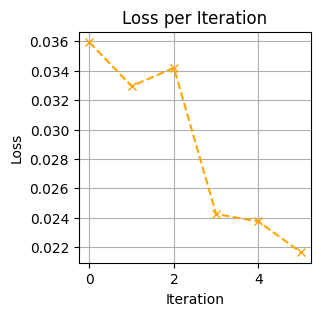

In [175]:
plt.plot(loss_list, label='Test', linestyle='--', marker='x', color='orange')
plt.title("Loss per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.grid()
plt.show()

### 16개 개별비교

In [176]:
def visualize_patches_total(X, y, X_hat):

    fig, axes = plt.subplots(3, 16, figsize=(32, 6))  # 3행 16열로 설정
    fig.suptitle("Patches", fontsize=12, y=1.05)  # 전체 제목 추가

    for i in range(X.shape[0]):  # 16개의 이미지만큼 반복
        # X 데이터 시각화
        axes[0, i].imshow(X[i], cmap='gray', vmin=-200, vmax=300)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"X {i+1}", fontsize=12)
        
        # y 데이터 시각화
        axes[1, i].imshow(y[i], cmap='gray', vmin=-200, vmax=300)
        axes[1, i].axis('off')
        axes[1, i].set_title(f"y {i+1}", fontsize=12)
        
        # X_hat 데이터 시각화
        axes[2, i].imshow(X_hat[i], cmap='gray', vmin=-200, vmax=300)
        axes[2, i].axis('off')
        axes[2, i].set_title(f"X_hat {i+1}", fontsize=12)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # 제목 위치 조정
    plt.show()


In [177]:
# 1. 랜덤비교

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)
test_iter = iter(test_loader)
len(test_iter)

6025

In [178]:
idx = 400 # 1~6025 여기 안에서 선택
for i in range(idx):
    X_test, y_test = next(test_iter)
    
X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(model(X_test.cuda()).cpu().detach()).numpy() * 500 - 500

In [179]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

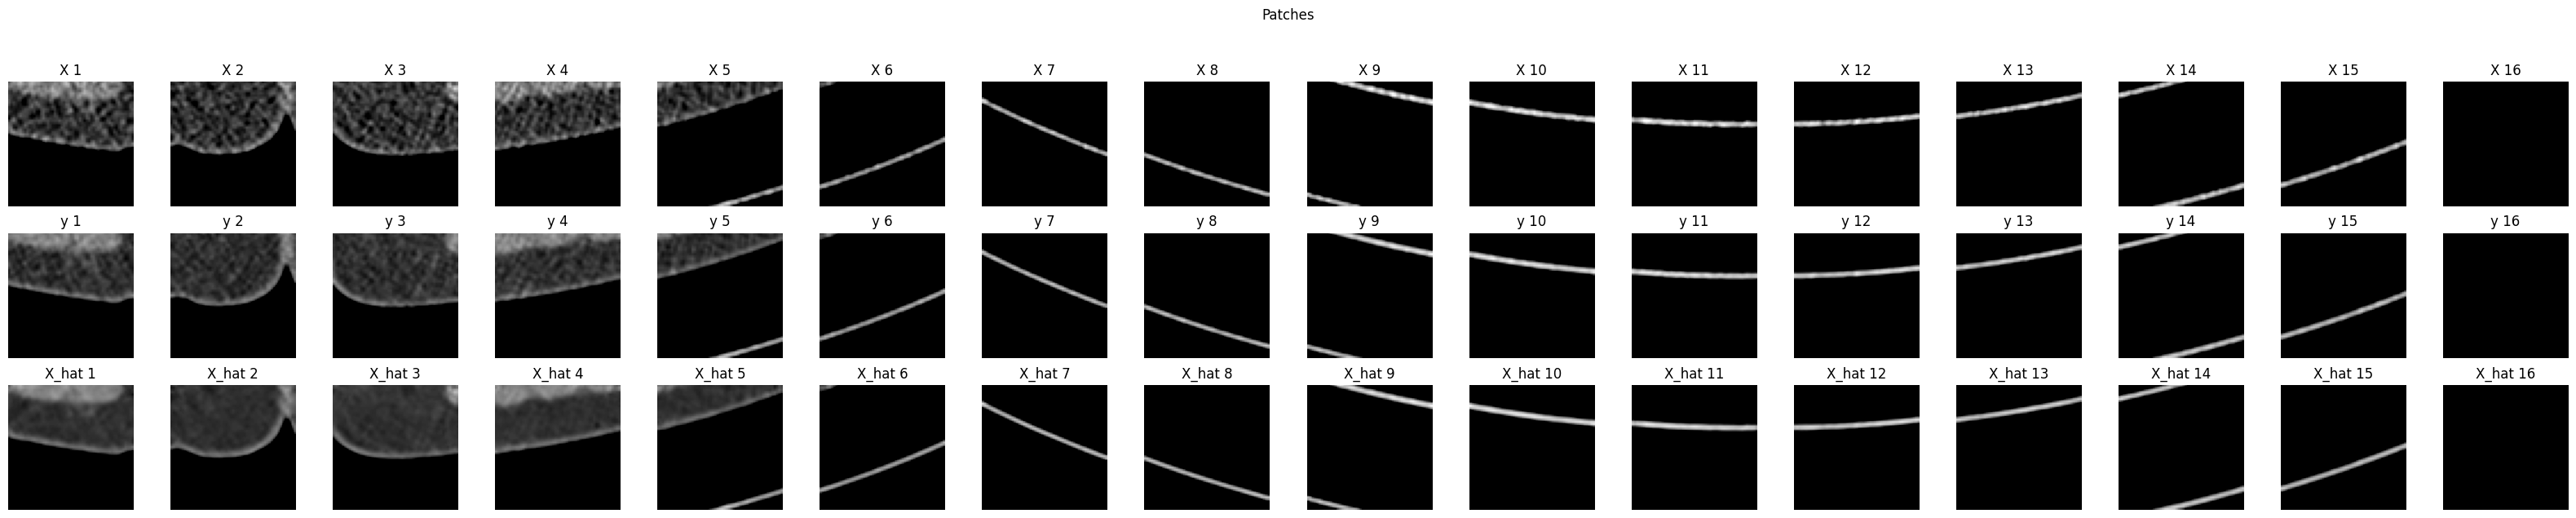

In [180]:
visualize_patches_total(X, y, X_hat)

In [181]:
# 2. 가장 loss가 낮은 값 확인

X_test,y_test,X_hat = best

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(model(X_test.cuda()).cpu().detach()).numpy() * 500 - 500

In [182]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

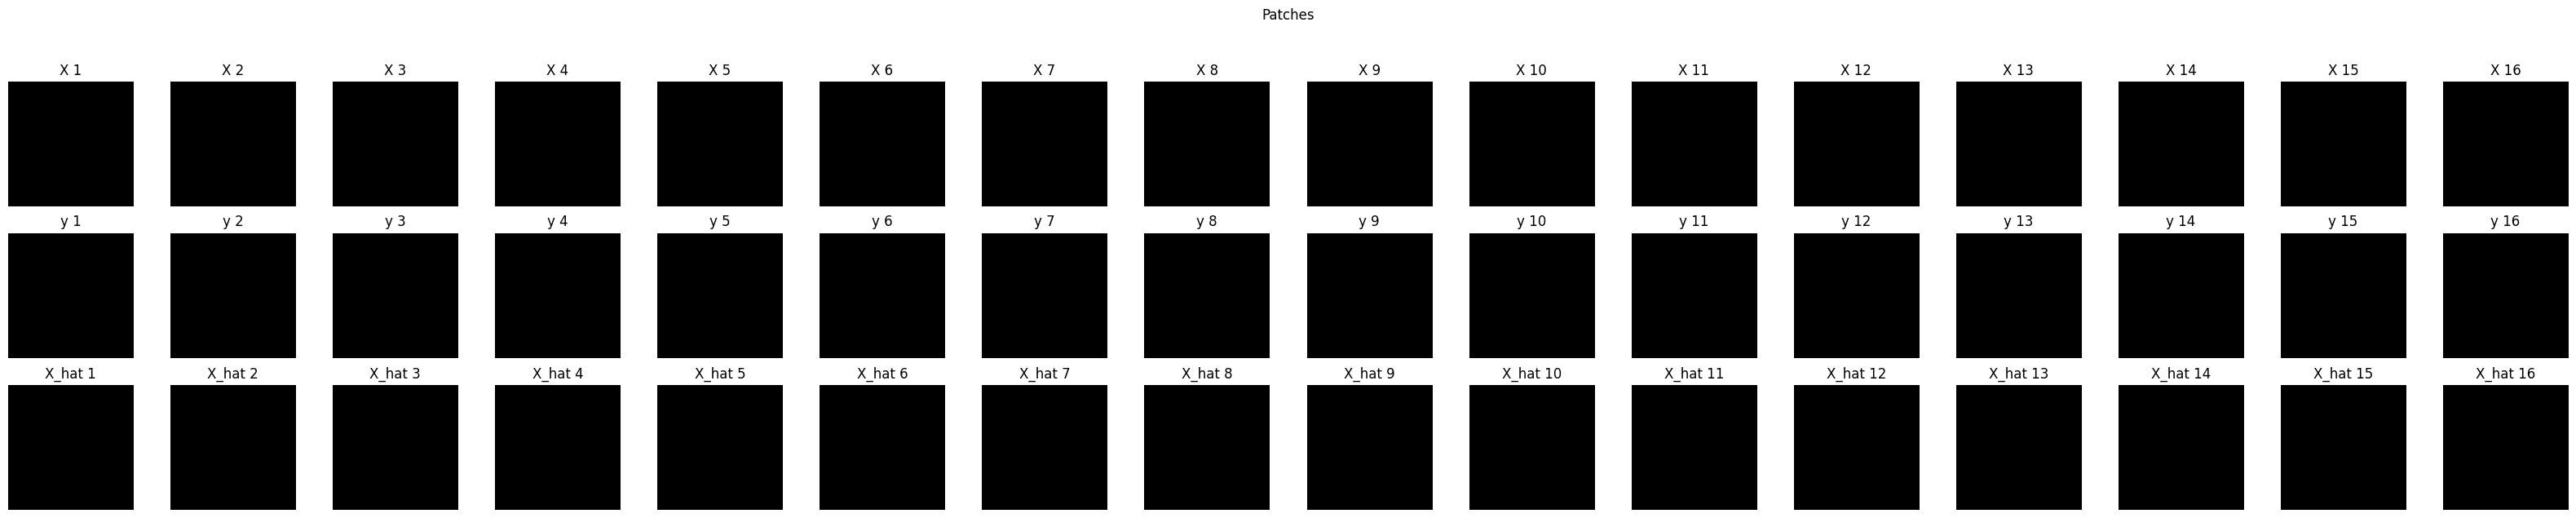

In [183]:
visualize_patches_total(X, y, X_hat)

In [184]:
# 3. 가장 loss가 높은 값 확인

X_test,y_test,X_hat = worst

X = np.squeeze(X_test.cpu().numpy()) * 500 - 500
y = np.squeeze(y_test.cpu().numpy()) * 500 - 500
X_hat = np.squeeze(model(X_test.cuda()).cpu().detach()).numpy() * 500 - 500

In [185]:
X.shape, y.shape, X_hat.shape

((16, 55, 55), (16, 55, 55), (16, 55, 55))

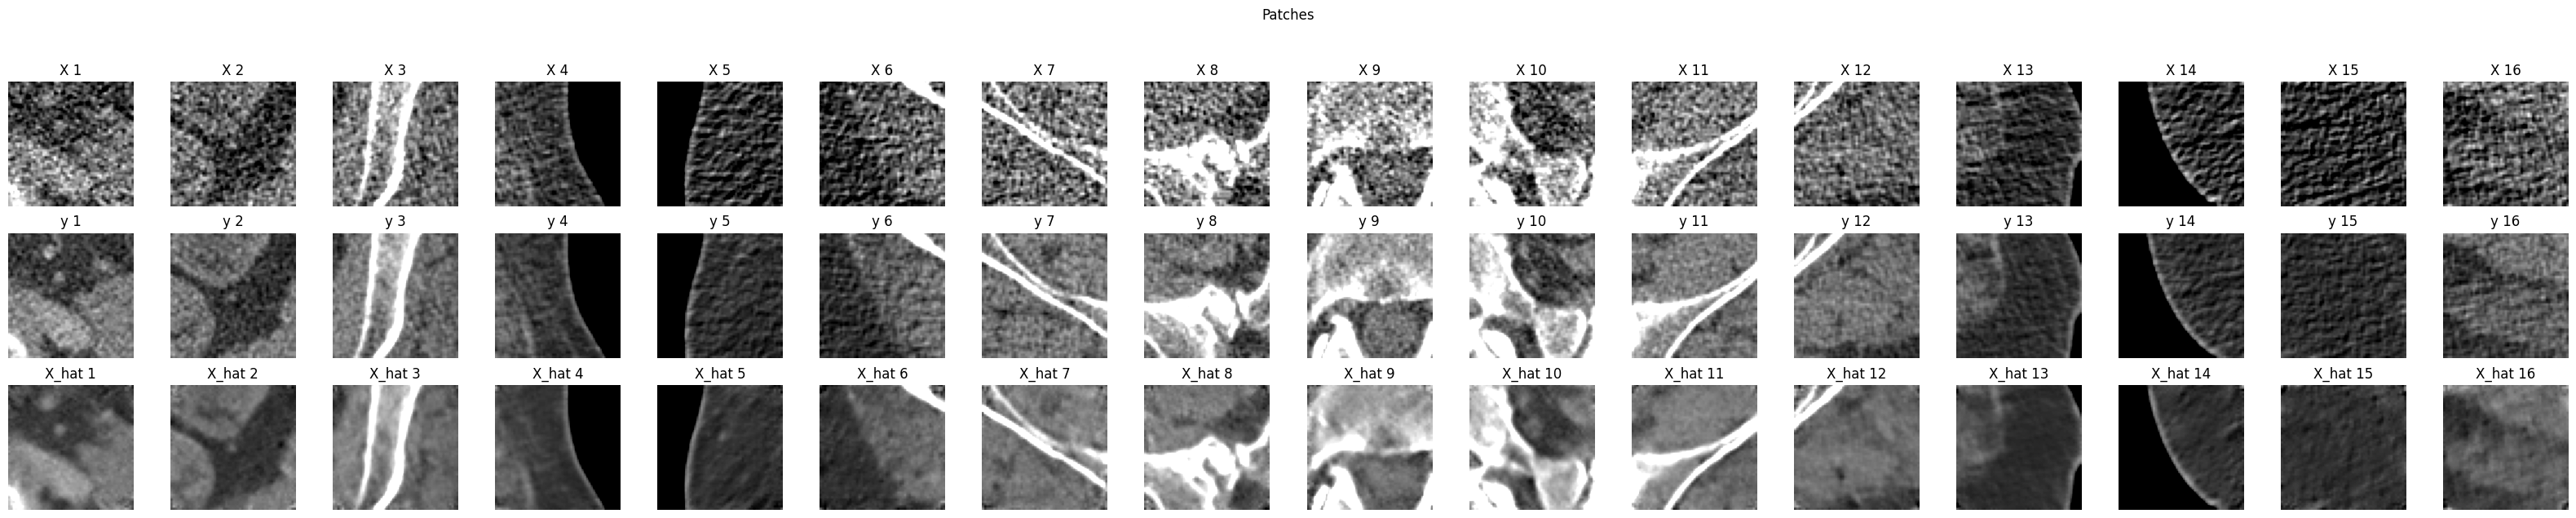

In [186]:
visualize_patches_total(X, y, X_hat)

## batch size = 81

In [187]:
criterion = nn.MSELoss()
interval = 1000

# 저장된 모델 로드
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RedCNN().to(device)
model.load_state_dict(torch.load('red_cnn.pth'))

<All keys matched successfully>

In [188]:
test_loader = DataLoader(test_dataset, batch_size=81, shuffle=False, num_workers=0)
len(test_loader)

1190

In [189]:
# evaluate부분 + top10 best&worst
model.eval()
running_loss = 0.0
loss_list = []
total_loss = 0
best_loss = np.inf
worst_loss = -np.inf

with torch.no_grad():
    for i, data in tqdm(enumerate(test_loader), total=len(test_loader), desc=f"Evaluating"):
        X, y = data[0].to(device), data[1].to(device)
        X_hat = model(X)
        loss = criterion(X_hat, y)

        if loss < best_loss:
            best_loss = loss
            best = (X,y,X_hat)
        if loss > worst_loss:
            worst_loss = loss
            worst = (X,y,X_hat)

        running_loss += loss.item() * X.size(0)

        if i % interval == interval-1:
            interval_loss = running_loss / interval
            loss_list.append(interval_loss)
            total_loss += running_loss
            running_loss = 0.0
            tqdm.write(f'train loss : {interval_loss}')

Evaluating:  84%|████████▍ | 1004/1190 [00:24<00:05, 33.12it/s]

train loss : 0.1527152997571975


Evaluating: 100%|██████████| 1190/1190 [00:29<00:00, 39.70it/s]


### 함수정의

In [190]:
def reconstruct_image(prediction, num_patches_per_row=9, patch_size=55):
    # prediction: (81, 1, 55, 55) 크기의 torch 텐서
    num_patches = prediction.shape[0]  # 81개의 패치
    assert prediction.shape == (81, 1, 55, 55) # "패치의 크기가 올바르지 않습니다."
    
    # 최종적으로 1x495x495 크기의 이미지를 만들기 위한 초기화
    final_image = torch.zeros(1, num_patches_per_row * patch_size, num_patches_per_row * patch_size)
    
    # 9x9 배열로 패치 붙이기
    for i in range(num_patches):
        row = i // num_patches_per_row  # 현재 패치의 행 번호
        col = i % num_patches_per_row   # 현재 패치의 열 번호
        
        # 패치를 해당 위치에 붙이기
        final_image[:, 
                    row * patch_size:(row + 1) * patch_size, 
                    col * patch_size:(col + 1) * patch_size] = prediction[i, 0]

    return final_image

In [191]:
def extract_patches(img, patch_size=55, interval=55):
    patches = []
    _, height, width = img.shape
    for y in range(0, height - patch_size + 1, interval):
        for x in range(0, width - patch_size + 1, interval):
            patch = img[:, y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    patches = torch.stack(patches)  # 리스트를 텐서로 변환
    return patches  # 반환 형태는 patch 수 x 1 x 55 x 55

In [192]:
def rescale(img):
    return img*500-500 # -1000부터 2000의 값으로 다시 변환

In [193]:
def trans_img(X):
    return rescale(np.squeeze(reconstruct_image(X)))

In [194]:
X_test,y_test,X_hat = best
trans_img(X_test).min(), trans_img(X_test).max()

(tensor(-1024.), tensor(1862.))

In [195]:
trans_img(X_test).shape

torch.Size([495, 495])

In [196]:
!pwd

/root/code/redcnn/base


In [197]:
def save_img(X_test, X_hat, y_test, s):
    # X_test 저장
    numpy_X_test = trans_img(X_test).numpy()
    np.save(f'X_test_image{s}.npy', numpy_X_test)
    
    # X_hat 저장
    numpy_X_hat = trans_img(X_hat).numpy()
    np.save(f'X_hat_image{s}.npy', numpy_X_hat)
    
    # y_test 저장
    numpy_y_test = trans_img(y_test).numpy()
    np.save(f'y_test_image{s}.npy', numpy_y_test)

### 1. best

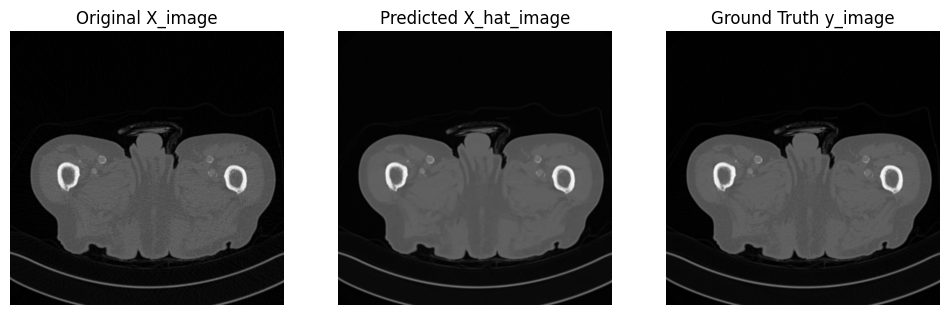

In [198]:
# 1. 가장 좋은 값 가져오기
X_test,y_test,X_hat = best

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray')
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray')
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray')
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

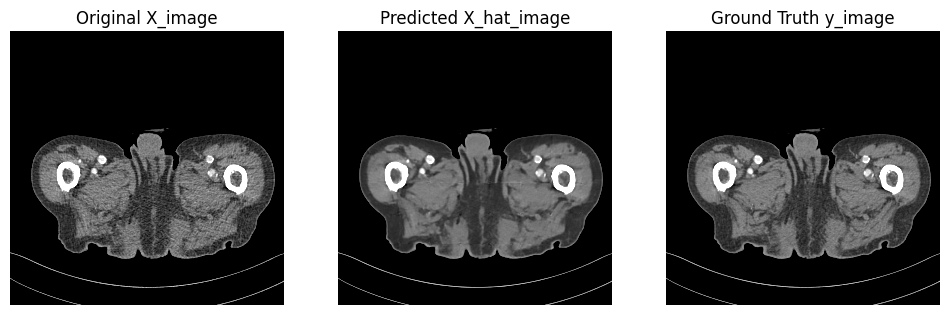

In [199]:
# 1. 가장 좋은 값 가져오기
X_test,y_test,X_hat = best

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [200]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'best')

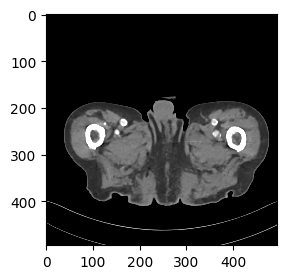

In [201]:
# 불러오기

import numpy as np

s = 'best'
X_test = np.load(f'X_hat_image{s}.npy')

plt.imshow(X_test, cmap='gray', vmin=-200, vmax=300)

### 2. worst

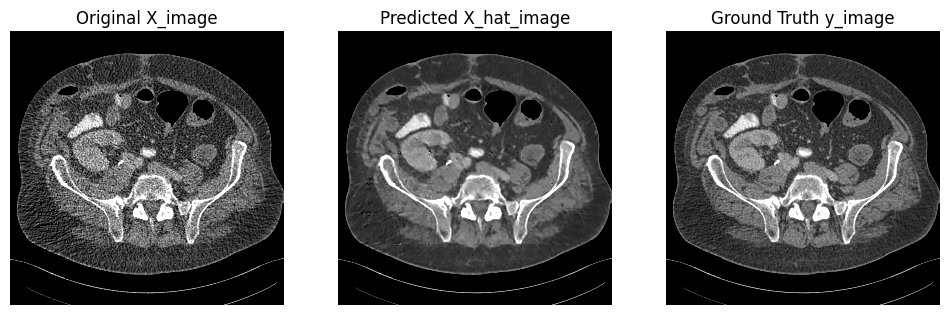

In [202]:
# 2. 가장 나쁜 값 가져오기
X_test,y_test,X_hat = worst

# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(trans_img(X_test), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(trans_img(X_hat), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(trans_img(y_test), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [203]:
# 이미지 저장

save_img(X_test, X_hat, y_test, 'worst')

### 3. 랜덤

In [204]:
import glob
# 3. 랜덤선택

i,j = 0,0
X_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
y_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]

X_image, y_image = normlize(X_dir), normlize(y_dir)
X_patches = extract_patches(torch.from_numpy(X_image))

X_image.shape, y_image.shape, X_patches.shape

((1, 512, 512), (1, 512, 512), torch.Size([81, 1, 55, 55]))

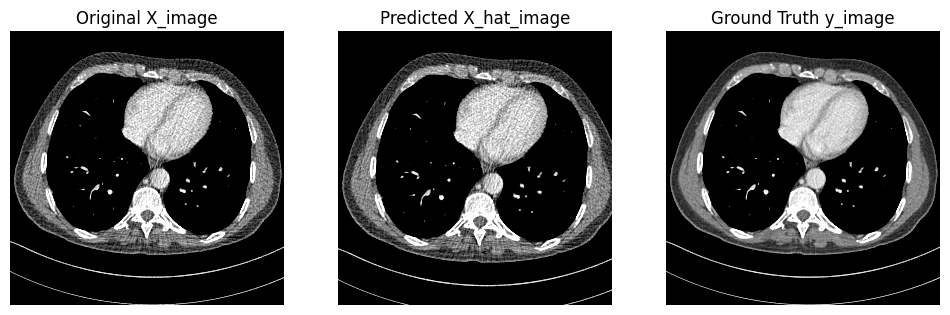

In [205]:
# 세 개의 이미지를 한 줄에 그리기
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# X_image 표시
axes[0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
axes[0].set_title("Original X_image")
axes[0].axis('off')  # 축 숨기기

# X_hat_image 표시
axes[1].imshow(rescale(np.squeeze(reconstruct_image(X_patches))), cmap='gray', vmin=-200, vmax=300)
axes[1].set_title("Predicted X_hat_image")
axes[1].axis('off')  # 축 숨기기

# y_image 표시
axes[2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
axes[2].set_title("Ground Truth y_image")
axes[2].axis('off')  # 축 숨기기

# 이미지 보여주기
plt.show()

In [206]:
!pwd

/root/code/redcnn/base


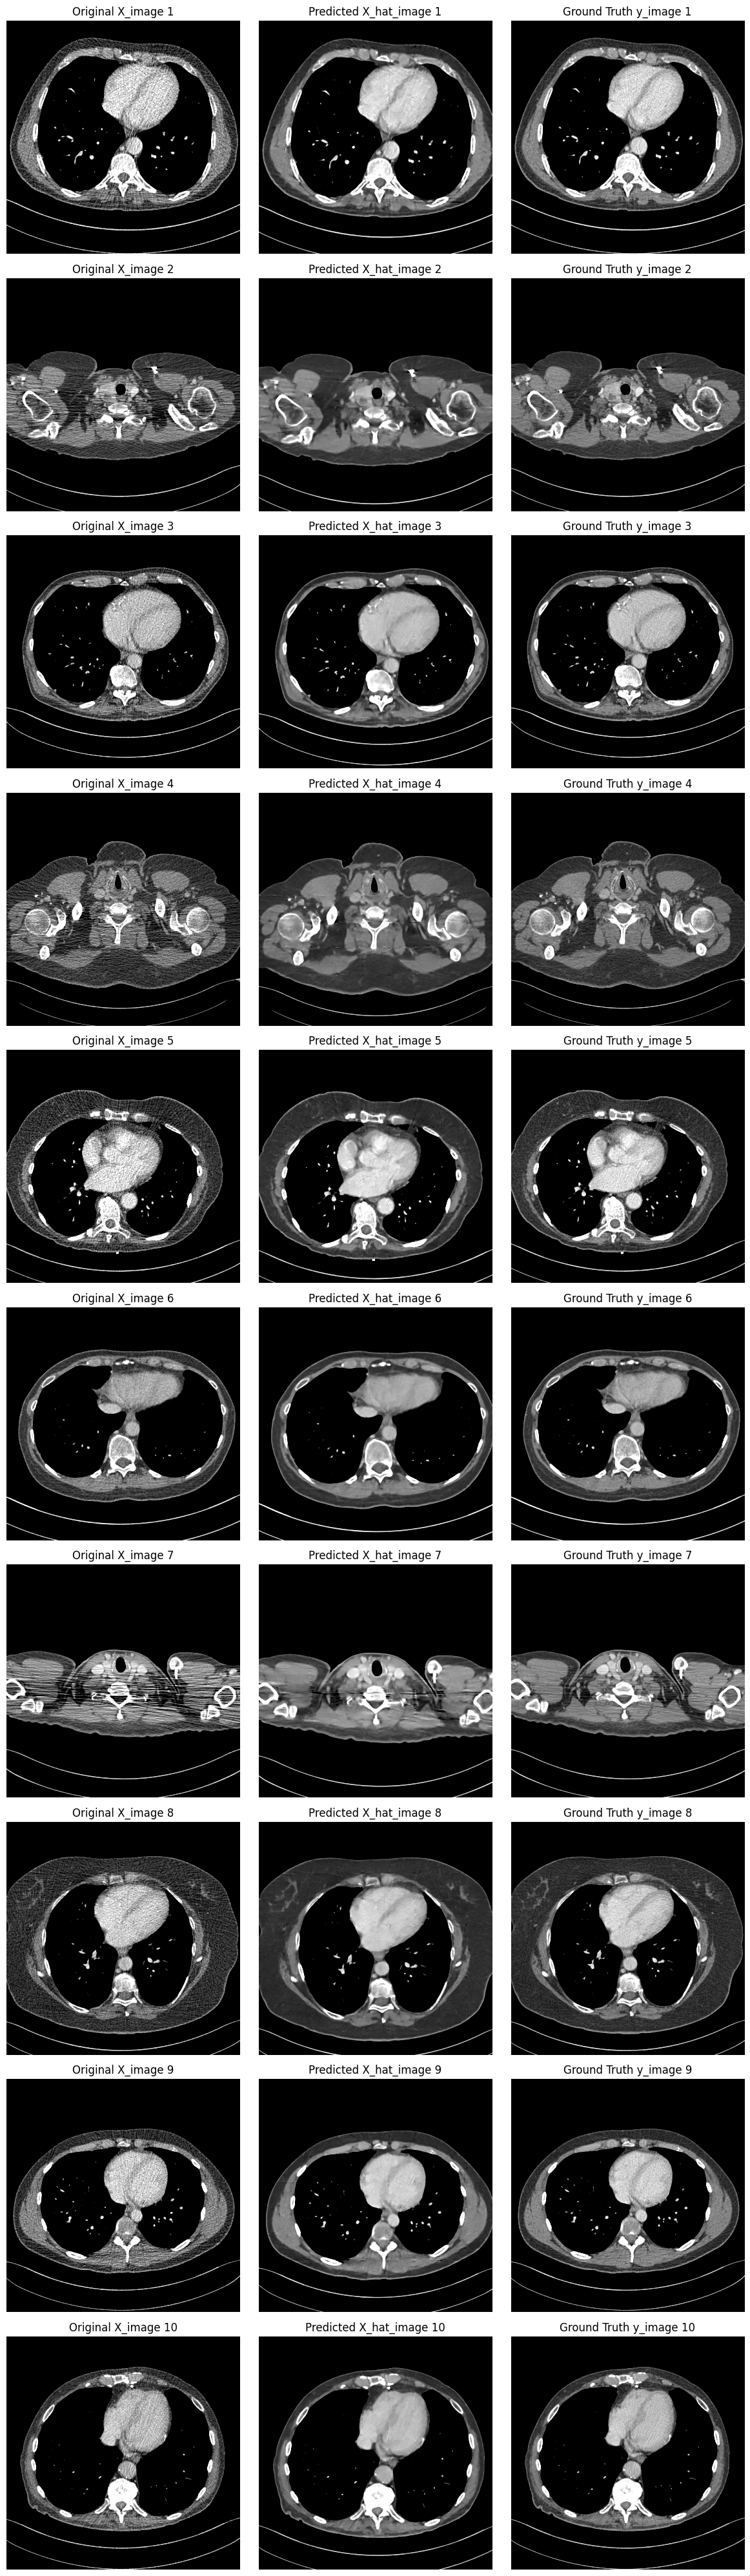

In [209]:
import matplotlib.pyplot as plt
import numpy as np

i, n = 0, 10
L = L_list[i]

# 전체 이미지 배열을 생성
fig, axes = plt.subplots(n, 3, figsize=(12, 4 * n))

for i in range(n):
    X_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[0]}/*.IMA'))[j]
    y_dir = sorted(glob.glob(f'/root/Mayo2016/{L_list[i]}/{data_label[1]}/*.IMA'))[j]
    X_image, y_image = normlize(X_dir), normlize(y_dir)
    X_patches = extract_patches(torch.from_numpy(X_image))
    X_hat_patches = model(X_patches.cuda()).cpu().detach()
    reconstructed_image = reconstruct_image(X_hat_patches)

    # X_image 표시
    axes[i, 0].imshow(rescale(np.squeeze(X_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 0].set_title(f"Original X_image {i+1}")
    axes[i, 0].axis('off')

    # X_hat_image 표시
    axes[i, 1].imshow(rescale(np.squeeze(reconstructed_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 1].set_title(f"Predicted X_hat_image {i+1}")
    axes[i, 1].axis('off')

    # y_image 표시
    axes[i, 2].imshow(rescale(np.squeeze(y_image)), cmap='gray', vmin=-200, vmax=300)
    axes[i, 2].set_title(f"Ground Truth y_image {i+1}")
    axes[i, 2].axis('off')

# 모든 이미지 저장
plt.tight_layout()
plt.savefig("comparison_images.png", format="png")  # 한번에 저장
plt.show()  # 모든 이미지 표시